In [10]:
import pickle
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt
%matplotlib inline


class Detection:
    def __init__(self, x, y, deg):
        self.x = x
        self.y = y
        self.orientation = deg
    def data(self):
        print(self.x,self.y,self.orientation)
 

In [11]:
#small trick to increase the dataset size: A single track may have >500 detections, even after /15 reduction.
#So be split every track into multiple tracks of 150 length.
def splitChunks(t):
    trackChunks = []
    while (len(t)>=min_track_length+track_smoothing_window_size+3):
        currentTrack = t[0:min_track_length+track_smoothing_window_size+2]
        t = t[min_track_length+track_smoothing_window_size+2:len(t)]
        trackChunks = trackChunks + [currentTrack]
    return trackChunks



def getTracks(f):
    i = 0
    tracks = []
    for line in f:
        i = i+1
        if (i<50):
            continue
        if (i%15 != 0): #really cheap way to sparse out data...
            continue
        l = line.split(';')
        try:
            d = Detection(float(l[9]), float(l[10]), float(l[11]))
            tracks = tracks + [d]
        except:
            break
    chunks = splitChunks(tracks)
    #print(chunks)
    return chunks



def readDir(file):
    array = np.load(file)
    print(array)
    tracks = []
    #f = open(folder, 'r')
    for x in array:
        d = Detection(float(x[0]), float(x[1]), float(x[2]))
        tracks = tracks + [d]
    chunks = splitChunks(tracks)
    return chunks

In [12]:

track_path = '/Users/mehmedhalilovic/Desktop/DataScience/Tracks.npy'
min_track_length = 50
track_smoothing_window_size = 15
track_smoothing_std = .5
num_discretization_bins = 12
print("test")
tracks = readDir(track_path)

num_batches = 100
num_hidden = 12
batch_size = 5



#Hier steht: [[detection]]
print(tracks)



test
[[ 341.02173351  219.63755083  -27.84708116]
 [ 346.32691813  222.440231    -27.84708116]
 [ 351.63210275  225.24291117  -27.84708116]
 ..., 
 [  51.02928454  224.63036212  -27.84708116]
 [  56.33446916  227.43304229  -27.84708116]
 [  61.63965378  230.23572246  -27.84708116]]
[[<__main__.Detection object at 0x11e2f3ef0>, <__main__.Detection object at 0x11e2f3e80>, <__main__.Detection object at 0x11e2f3f60>, <__main__.Detection object at 0x11e2f3f28>, <__main__.Detection object at 0x11e2f34e0>, <__main__.Detection object at 0x11e2ee048>, <__main__.Detection object at 0x11e2ee080>, <__main__.Detection object at 0x11e2ee0b8>, <__main__.Detection object at 0x11e2ee0f0>, <__main__.Detection object at 0x11e2ee160>, <__main__.Detection object at 0x11e2ee128>, <__main__.Detection object at 0x11e2ee1d0>, <__main__.Detection object at 0x11e2ee208>, <__main__.Detection object at 0x11e2ee240>, <__main__.Detection object at 0x11e2ee278>, <__main__.Detection object at 0x11e2ee2b0>, <__main__.D

In [13]:

def preprocess_detection(detection):
    #print(detection)
    return detection.x, detection.y, np.cos(detection.orientation), np.sin(detection.orientation)

def preprocess_track(track):
    #print(track)
    return [preprocess_detection(detection) for detection in track]



tracks = [preprocess_track(track) for track in tracks]
tracks = list(filter(lambda t: len(t) > min_track_length + track_smoothing_window_size + 1, tracks))
tracks = list(map(np.array, tracks))
num_features = tracks[0].shape[-1]





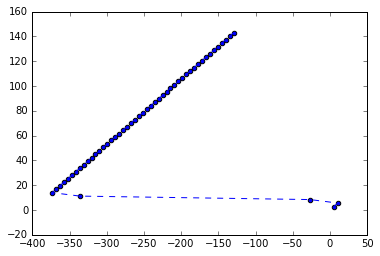

In [14]:
def smoothen_track(track, std=track_smoothing_std):
    track_smooth = pd.DataFrame(track).rolling(window=track_smoothing_window_size, win_type='gaussian')
    return track_smooth.mean(std=std).as_matrix()[track_smoothing_window_size:]

tracks = list(map(smoothen_track, tracks))
tracks = list(map(lambda t: np.diff(t, axis=0), tracks))



plt.scatter(np.cumsum(tracks[0][:, 0]), np.cumsum(tracks[0][:, 1]))
plt.plot(np.cumsum(tracks[0][:, 0]), np.cumsum(tracks[0][:, 1]), '--')


In [15]:
def get_discretization_bins(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    return cutoffs

discretization_bins = []
concatenated_tracks = np.concatenate(tracks)
for feature_i in range(num_features):
    discretization_bins.append(
        get_discretization_bins(concatenated_tracks[:, feature_i], 
                                num_discretization_bins))
del(concatenated_tracks)


In [19]:

def digitize_track(track):
    for feature_i in range(num_features):
        track[:, feature_i] = np.digitize(track[:, feature_i], discretization_bins[feature_i], right=True)
    return track.astype(np.int32)


np.random.shuffle(tracks)
train_tracks = tracks[:int(.8 * len(tracks))]
val_tracks = tracks[int(.8 * len(tracks)):]
print(len(train_tracks), len(val_tracks))

#num_hidden = 32
#batch_size = 22


tf.reset_default_graph()

track_continuous = tf.placeholder(tf.float32, shape=(None, min_track_length, num_features))
track_discrete = tf.placeholder(tf.int32, shape=(None, min_track_length, num_features))

inputs = track_continuous[:, :-1, :]
targets = track_discrete[:, 1:, :]

with tf.variable_scope('discriminator'):
    disc_hidden_0, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        inputs, dtype=tf.float32, scope='disc_hidden_0')
    disc_hidden_1, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        disc_hidden_0, dtype=tf.float32, scope='disc_hidden_1')
    disc_hidden_2, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        disc_hidden_1, dtype=tf.float32, scope='disc_hidden_2')
    # add optional classifier here
    
with tf.variable_scope('generator'):
    gen_hidden_2, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        disc_hidden_2, dtype=tf.float32, scope='gen_hidden_2')
    gen_hidden_1_input = tf.concat((gen_hidden_2, disc_hidden_1), axis=2)
    gen_hidden_1, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        gen_hidden_1_input, dtype=tf.float32, scope='gen_hidden_1')
    gen_hidden_0_input = tf.concat((gen_hidden_1, disc_hidden_0), axis=2)
    gen_hidden_0, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        gen_hidden_0_input, dtype=tf.float32, scope='gen_hidden_0')
    gen_output, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.OutputProjectionWrapper(
            tf.contrib.rnn.GRUCell(num_hidden), num_features * num_discretization_bins), 
        gen_hidden_0, dtype=tf.float32, scope='gen_features')
    gen_output = tf.reshape(gen_output,
        (tf.shape(gen_output)[0], tf.shape(gen_output)[1], num_features, num_discretization_bins))
    
loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=targets, logits=gen_output))


optimizer = tf.train.AdamOptimizer(0.01)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    update = optimizer.minimize(loss)

def subsample(track):
    start_idx = np.random.randint(0, track.shape[0] - min_track_length)
    end_idx = start_idx + min_track_length
    return track[start_idx:end_idx]

def data_generator(tracks, size=batch_size):
    while True:
        indices = np.random.choice(list(range(len(tracks))), replace=True, size=size)
        samples = [track for idx, track in enumerate(tracks) if idx in indices]
        sampled_tracks = np.array(list(map(subsample, samples)))
        digitized_tracks = np.array(list(map(lambda t: digitize_track(t), np.copy(sampled_tracks))))
        yield sampled_tracks, digitized_tracks


59 15


99: train-logloss: 1.04, val-logloss: 1.02

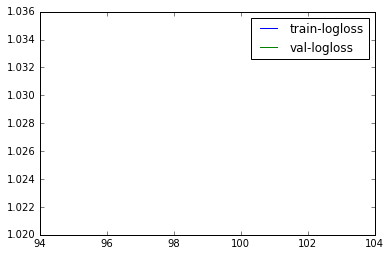

In [20]:
train_gen = data_generator(train_tracks)
val_gen = data_generator(val_tracks)

session = tf.Session()
session.run(tf.global_variables_initializer())

train_losses = []
val_losses = []

for batch_idx in range(num_batches):
    samples_continuous, samples_discrete = next(train_gen)
    batch_loss, _ = session.run([loss, update], feed_dict={track_continuous: samples_continuous,
                                              track_discrete: samples_discrete})
    train_losses.append(batch_loss)
    
    samples_continuous, samples_discrete = next(val_gen)
    batch_loss = session.run(loss, feed_dict={track_continuous: samples_continuous,
                                              track_discrete: samples_discrete})
    val_losses.append(batch_loss)
    
    sys.stdout.write('\r{}: train-logloss: {:.2f}, val-logloss: {:.2f}'.format(
        batch_idx, np.mean(train_losses[-100:]), np.mean(val_losses[-100:])))

plt.plot(pd.Series(train_losses).rolling(100).mean(), label='train-logloss')
plt.plot(pd.Series(val_losses).rolling(100).mean(), label='val-logloss')
plt.legend()





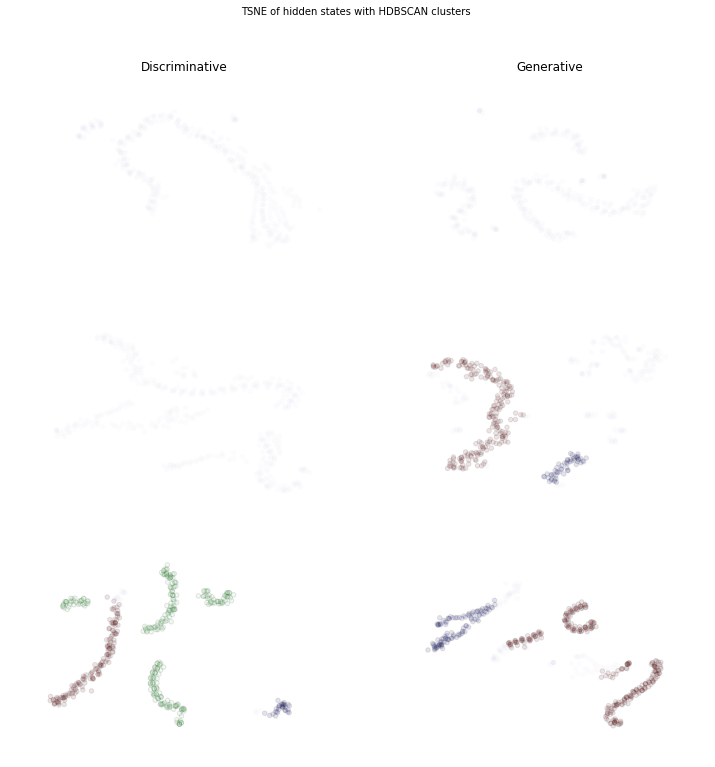

In [21]:

val_gen = data_generator(val_tracks, size=16)
samples_continuous, _ = next(val_gen)

disc_hidden = []
disc_hidden_2d = []
disc_hidden_labels = []

for hidden in (disc_hidden_2, disc_hidden_1, disc_hidden_0):
    hidden_states = session.run(hidden, feed_dict={track_continuous: samples_continuous})
    hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))
    hidden_states_2d = TSNE().fit_transform(hidden_states.astype(np.float64))
    clusterer = HDBSCAN(min_cluster_size=25)
    cluster_labels = clusterer.fit_predict(hidden_states)
    disc_hidden.append(hidden_states)
    disc_hidden_2d.append(hidden_states_2d)
    disc_hidden_labels.append(cluster_labels)

gen_hidden = []
gen_hidden_2d = []
gen_hidden_labels = []

for hidden in (gen_hidden_2, gen_hidden_1, gen_hidden_0):
    hidden_states = session.run(hidden, feed_dict={track_continuous: samples_continuous})
    hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))
    hidden_states_2d = TSNE().fit_transform(hidden_states.astype(np.float64))
    clusterer = HDBSCAN(min_cluster_size=25)
    cluster_labels = clusterer.fit_predict(hidden_states)
    gen_hidden.append(hidden_states)
    gen_hidden_2d.append(hidden_states_2d)
    gen_hidden_labels.append(cluster_labels)


fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for idx, (hidden, hidden_2d, clusters) in enumerate(zip(disc_hidden, disc_hidden_2d, disc_hidden_labels)):
    cluster_indices = np.where(clusters != -1)[0]
    
    axes[idx, 0].scatter(hidden_2d[:, 0], hidden_2d[:, 1], alpha=.01)
    axes[idx, 0].scatter(hidden_2d[cluster_indices, 0], 
                         hidden_2d[cluster_indices, 1], 
                         alpha=.1, c=clusters[cluster_indices],
                         cmap=plt.cm.jet)
    axes[idx, 0].set_axis_off()
    
axes[0, 0].set_title('Discriminative')
    
for idx, (hidden, hidden_2d, clusters) in enumerate(zip(gen_hidden, gen_hidden_2d, gen_hidden_labels)):
    cluster_indices = np.where(clusters != -1)[0]
    
    axes[idx, 1].scatter(hidden_2d[:, 0], hidden_2d[:, 1], alpha=.01)
    axes[idx, 1].scatter(hidden_2d[cluster_indices, 0], 
                         hidden_2d[cluster_indices, 1], 
                         alpha=.1, c=clusters[cluster_indices],
                         cmap=plt.cm.jet)
    axes[idx, 1].set_axis_off()
    
axes[0, 1].set_title('Generative')
    
_ = plt.suptitle('TSNE of hidden states with HDBSCAN clusters')


